In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import shap

import h5py
import seaborn as sns
import pandas as pd
import random



import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns


import matplotlib.pyplot as plt
from matplotlib import rc, rc_context

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)



def readHDF5(path,
             inner_path,
             dtype=None,
             ):
    with h5py.File(path, 'r') as f:
        output = f[inner_path][:]

    if dtype is not None:
        output = output.astype(dtype)

    return output


/Users/alberto-mac/miniconda3/envs/spottingProjIntensityEnv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
experiment_name = "new_random_experiments"

# # For regression results:
# task_type = "regression"
# task_name = "regression_on_detected_per_mol_sum"

# For classification results:
task_type = "classification"
task_name = "detection_per_mol_sum"

In [11]:

# ----------------------------
# LOAD AND NORMALIZE DATA:
# ----------------------------
# Paths:
current_dir_path = Path("/Users/alberto-mac/EMBL_repos/spotting-project-regression")

result_dir = current_dir_path / "training_results" / experiment_name
predictions_path = result_dir / "collected_predictions.csv"

# Get matrix names:
predictions = pd.read_csv(predictions_path,
                          index_col=0)
matrices = predictions["matrix"].unique()
polarities = predictions["polarity"].unique()

# Load shap features from disk:
shap_features_dir = result_dir / task_name / "feature_selection_plots"
shap_features_collected = {pol: {} for pol in polarities}

data_collected = []
for i, polarity in enumerate(polarities):
    for matrix in matrices:
        shap_values = readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="shape_values")
        features = readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="train_x")
        feature_names = readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="selected_features").astype("str")

        for i, feat in enumerate(feature_names):
            data = pd.DataFrame(np.array([shap_values[:,i], features[:, i]]).T, columns=["shap", "feature_value"])
            data["matrix"] = matrix
            data["polarity"] = polarity
            data["Feature"] = feat.replace("_", " ").title()
            data_collected.append(data)
#
data_collected = pd.concat(data_collected)

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.


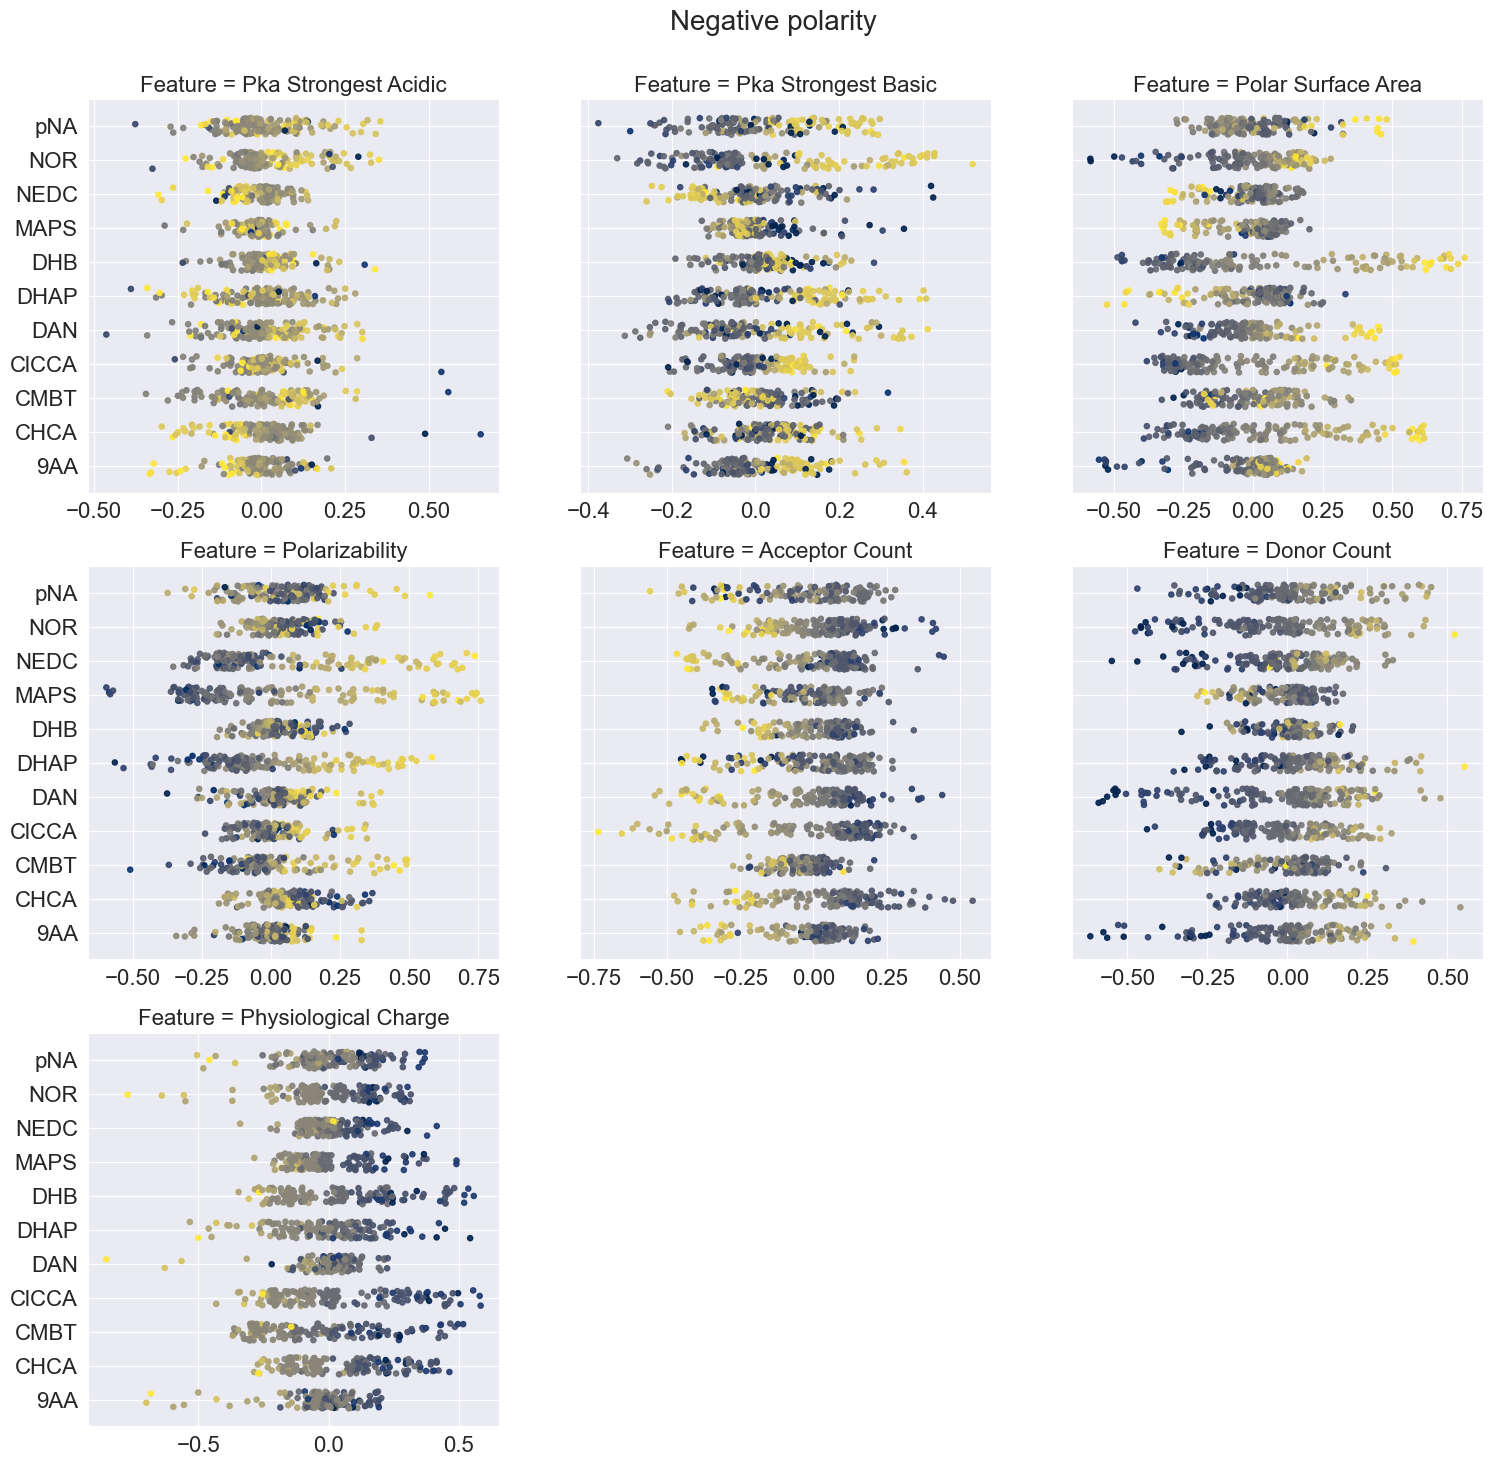

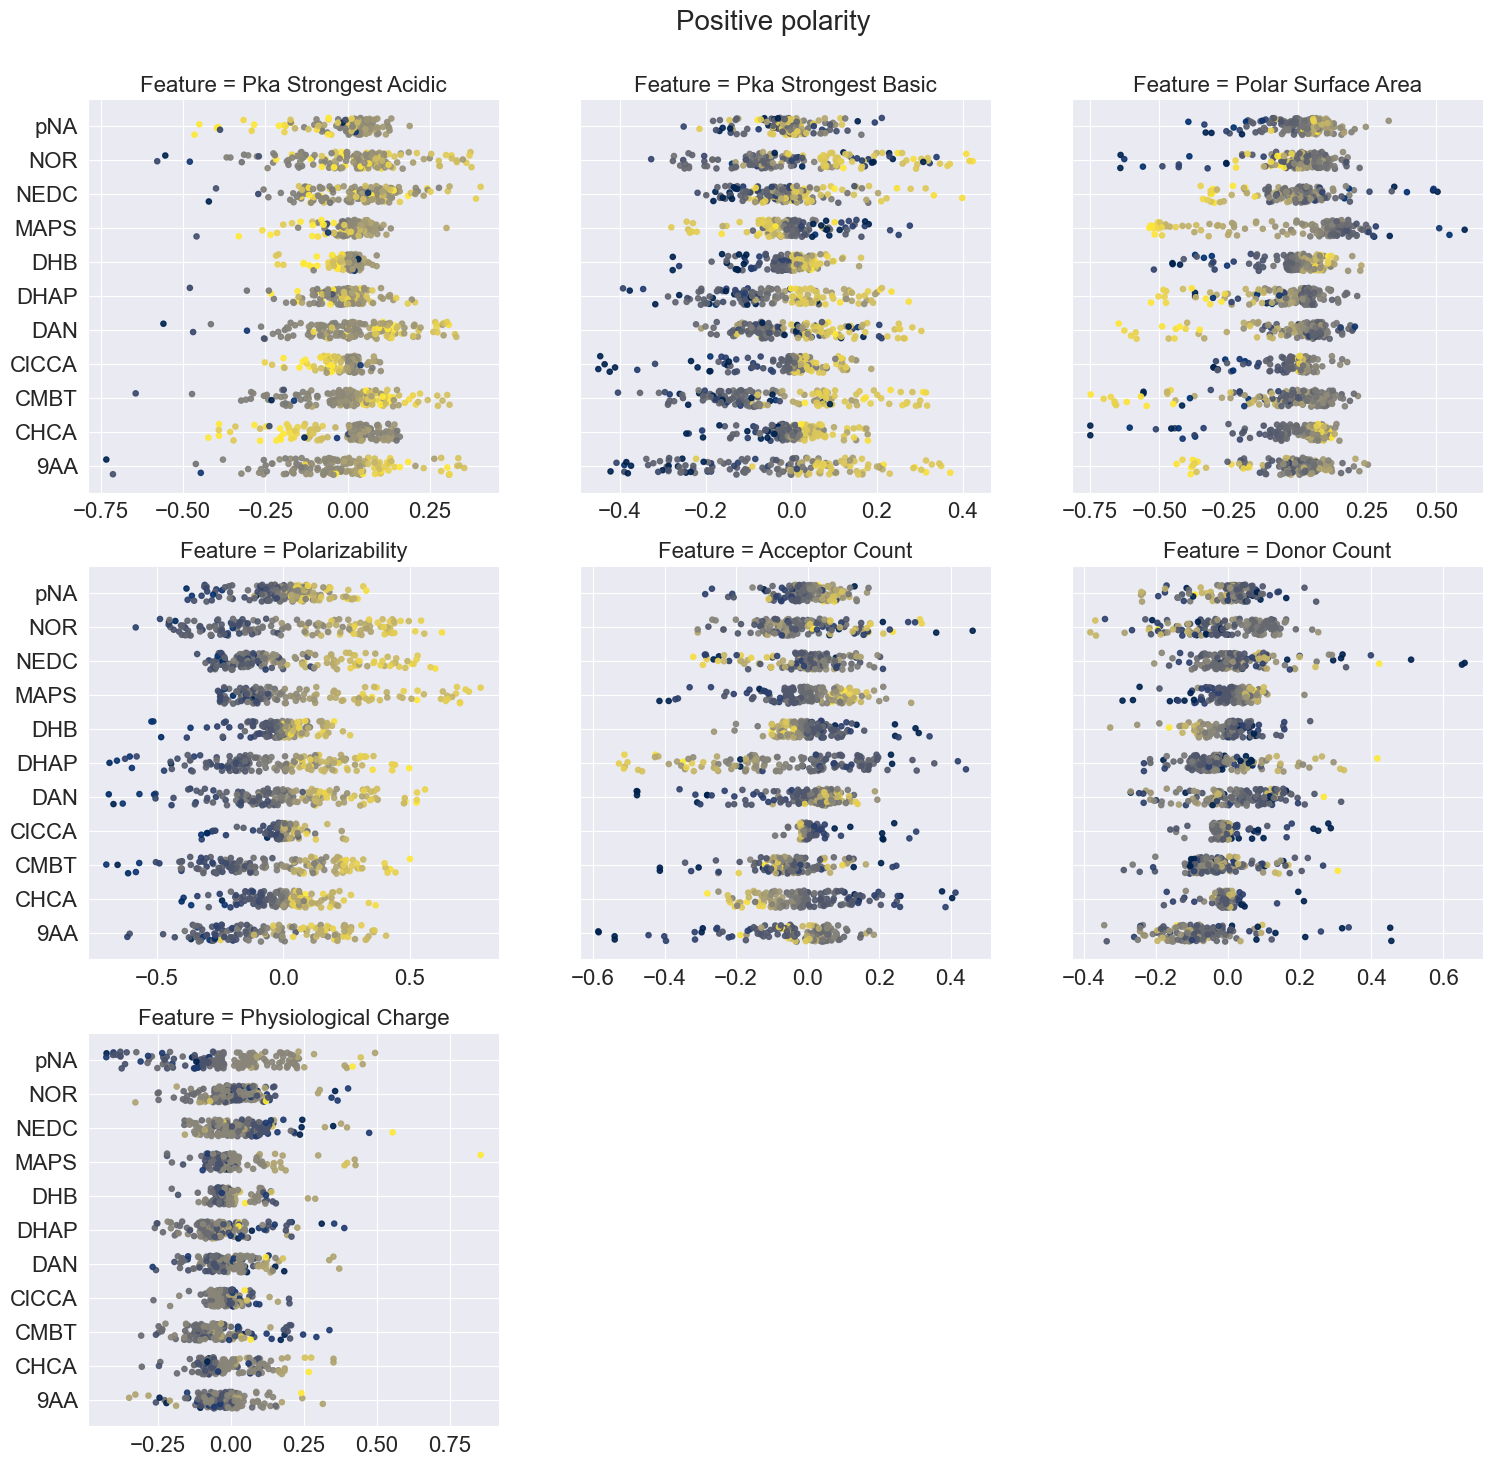

In [12]:

def jitter(x):
    return x + random.uniform(0, .5) -.25

matrix_id = {feat_name: i for i, feat_name in enumerate(matrices)}
data_collected['matrix_id'] = data_collected['matrix'].apply(lambda x: matrix_id[x])
data_collected['matrix_jitter'] = data_collected['matrix_id'].apply(lambda x: jitter(x))


for polarity, rows in data_collected.groupby(["polarity"]):
    g = sns.FacetGrid(rows,
                      col="Feature",
                      col_wrap=3,
                      height=5,
                     sharex=False)
    for (row_i, col_j, cue), data_ijk in g.facet_data():
        ax = g.facet_axis(row_i, col_j)
        ax.scatter(x='shap', y='matrix_jitter', c='feature_value', cmap='cividis',
                   data=data_ijk, s=14, alpha=0.9)
        ax.set_yticks([id for id in range(len(matrices))])
        ax.set_yticklabels(matrices)
    g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
    g.fig.suptitle(f"{polarity.capitalize()} polarity", size=20)
#     g.set_titles(col_template={})
    plt.show()
    g.fig.savefig(shap_features_dir / f"{task_type}_summary_shap_features_{polarity}_polarity.pdf")

#
# for i, polarity in enumerate(polarities):
#     data_collected.plot(kind='scatter', x='shap', y='matrix_jitter', c='feature_value', cmap='viridis',
#                        )
#     plt.yticks([id for id in range(len(matrices))])
#     plt.gca().set_yticklabels(matrices)
#     plt.show()


In [9]:
shap_features_dir

PosixPath('/Users/alberto-mac/EMBL_repos/spotting-project-regression/training_results/new_random_experiments/regression_on_detected_per_mol_sum/feature_selection_plots')

## Outdated stuff

In [48]:
# ----------------------------
# LOAD AND NORMALIZE DATA:
# ----------------------------
# Paths:
current_dir_path = Path("/Users/alberto-mac/EMBL_repos/spotting-project-regression")

result_dir = current_dir_path / "training_results" / experiment_name
predictions_path = result_dir / "collected_predictions.csv"

# Get matrix names:
predictions = pd.read_csv(predictions_path,
                          index_col=0)
matrices = predictions["matrix"].unique()
polarities = predictions["polarity"].unique()

# Load shap features from disk:
shap_features_dir = result_dir / task_name / "feature_selection_plots"
shap_features_collected = {pol: {} for pol in polarities}
for i, polarity in enumerate(polarities):
    for matrix in matrices:
        shap_features_collected[polarity][matrix] = [
            readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="shape_values"),
            readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="features_mask"),
            readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="train_x"),
            readHDF5(
                shap_features_dir / f"{matrix}_{polarity}_summary_plot_data.h5",
                inner_path="selected_features")
        ]


In [49]:
# features = shap_features_collected["negative"]["DAN"][3]
# np.isclose(shap_features_collected["negative"]["DAN"][2], shap_features_collected["negative"]["CHCA"][2])


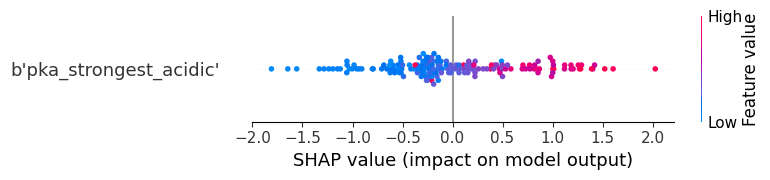

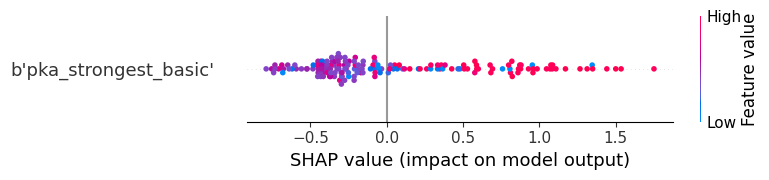

In [56]:
from predicting_APMALDI_response.beeswarm import summary_legacy
# cmap = colors.red_blue
alpha = 1

# for i, feat in enumerate(features):

shap_values = shap_features_collected["negative"]["DAN"][0]
features = shap_features_collected["negative"]["DAN"][2]
feature_names = shap_features_collected["negative"]["DAN"][3]

feature_order = range(len(feature_names))

summary_legacy(shap_values[:,:1], features[:,:1], feature_names[:1])
summary_legacy(shap_values[:,1:2], features[:,1:2], feature_names[1:2])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


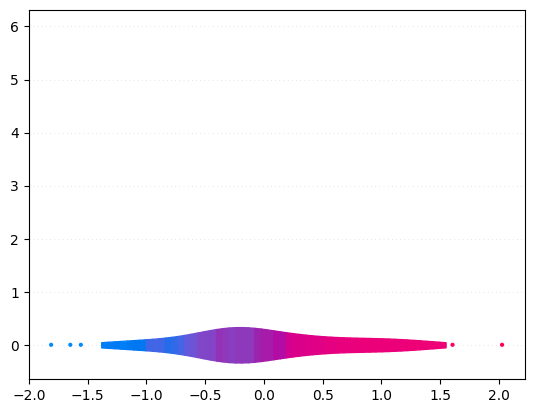

In [50]:

from scipy.stats import gaussian_kde
import shap.plots.colors as colors
cmap = colors.red_blue
alpha = 1

# for i, feat in enumerate(features):

shap_values = shap_features_collected["negative"]["DAN"][0]
features = shap_features_collected["negative"]["DAN"][2]
feature_names = shap_features_collected["negative"]["DAN"][3]

feature_order = range(len(feature_names))

for pos, i in enumerate(feature_order):
    plt.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)

# data = pd.DataFrame(np.array([shap_values[:,i], features[:, i]]).T, columns=["shap", "feature_value"])
# test = shap.summary_plot(shap_feat, features=X_train)
# data["matrix"] = "DAN"
# print(feat)

global_low = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 1)
global_high = np.nanpercentile(shap_values[:, :len(feature_names)].flatten(), 99)
for pos, i in enumerate(feature_order):
    shaps = shap_values[:, i]
    shap_min, shap_max = np.min(shaps), np.max(shaps)
    rng = shap_max - shap_min
    xs = np.linspace(np.min(shaps) - rng * 0.2, np.max(shaps) + rng * 0.2, 100)
    if np.std(shaps) < (global_high - global_low) / 100:
        ds = gaussian_kde(shaps + np.random.randn(len(shaps)) * (global_high - global_low) / 100)(xs)
    else:
        ds = gaussian_kde(shaps)(xs)
    ds /= np.max(ds) * 3

    values = features[:, i]
    window_size = max(10, len(values) // 20)
    smooth_values = np.zeros(len(xs) - 1)
    sort_inds = np.argsort(shaps)
    trailing_pos = 0
    leading_pos = 0
    running_sum = 0
    back_fill = 0
    for j in range(len(xs) - 1):

        while leading_pos < len(shaps) and xs[j] >= shaps[sort_inds[leading_pos]]:
            running_sum += values[sort_inds[leading_pos]]
            leading_pos += 1
            if leading_pos - trailing_pos > 20:
                running_sum -= values[sort_inds[trailing_pos]]
                trailing_pos += 1
        if leading_pos - trailing_pos > 0:
            smooth_values[j] = running_sum / (leading_pos - trailing_pos)
            for k in range(back_fill):
                smooth_values[j - k - 1] = smooth_values[j]
        else:
            back_fill += 1

    vmin = np.nanpercentile(values, 5)
    vmax = np.nanpercentile(values, 95)
    if vmin == vmax:
        vmin = np.nanpercentile(values, 1)
        vmax = np.nanpercentile(values, 99)
        if vmin == vmax:
            vmin = np.min(values)
            vmax = np.max(values)

    # plot the nan values in the interaction feature as grey
    nan_mask = np.isnan(values)
    plt.scatter(shaps[nan_mask], np.ones(shap_values[nan_mask].shape[0]) * pos,
               color="#777777", vmin=vmin, vmax=vmax, s=9,
               alpha=alpha, linewidth=0, zorder=1)
    # plot the non-nan values colored by the trimmed feature value
    cvals = values[np.invert(nan_mask)].astype(np.float64)
    cvals_imp = cvals.copy()
    cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
    cvals[cvals_imp > vmax] = vmax
    cvals[cvals_imp < vmin] = vmin
    plt.scatter(shaps[np.invert(nan_mask)], np.ones(shap_values[np.invert(nan_mask)].shape[0]) * pos,
               cmap=cmap, vmin=vmin, vmax=vmax, s=9,
               c=cvals, alpha=alpha, linewidth=0, zorder=1)
    # smooth_values -= nxp.nanpercentile(smooth_values, 5)
    # smooth_values /= np.nanpercentile(smooth_values, 95)
    smooth_values -= vmin
    if vmax - vmin > 0:
        smooth_values /= vmax - vmin
    for i in range(len(xs) - 1):
        if ds[i] > 0.05 or ds[i + 1] > 0.05:
            plt.fill_between([xs[i], xs[i + 1]], [pos + ds[i], pos + ds[i + 1]],
                            [pos - ds[i], pos - ds[i + 1]], color=colors.red_blue_no_bounds(smooth_values[i]),
                            zorder=2)

    # parts = plt.violinplot(shap_feat, range(shap_feat.shape[1]), points=200, vert=False,
    #                               widths=0.7,
    #                               showmeans=False, showextrema=False, showmedians=False)

    # print(data["feature_value"])
    # plot = sns.stripplot(
    #     data=data, x="shap", y="matrix", hue="feature_value",
    #     jitter=True,
    #      alpha=1, zorder=1,
    #     # legend=False,
    #     palette='coolwarm_r',
    # )
    # plot.get_legend().set_visible(False)
    # sns.despine()
    # plt.axhline(0, 0,1,color='grey').set_linestyle("--")
    #
    # #Drawing the side color bar
    # normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=data['feature_value'].min(), vmax=data['feature_value'].max())
    # colormap = cm.coolwarm_r
    #
    # [plt.plot(color=colormap(normalize(x))) for x in data['feature_value']]
    #
    # scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    # scalarmappaple.set_array(data['feature_value'])
    # # plt.colorbar(scalarmappaple)
    break


In [36]:
data

,shap,feature_value,matrix
0,-0.350927,-0.306086,DAN
1,-0.578598,-0.536624,DAN
2,0.188426,-0.031515,DAN
3,-1.284974,-0.780108,DAN
4,-0.047437,-0.133306,DAN
...,...,...,...
158,1.009225,0.781102,DAN
159,0.814001,1.170696,DAN
160,-0.686683,-0.478689,DAN
161,0.114109,0.164962,DAN


b'physiological_charge'


<Axes: xlabel='shap', ylabel='matrix'>

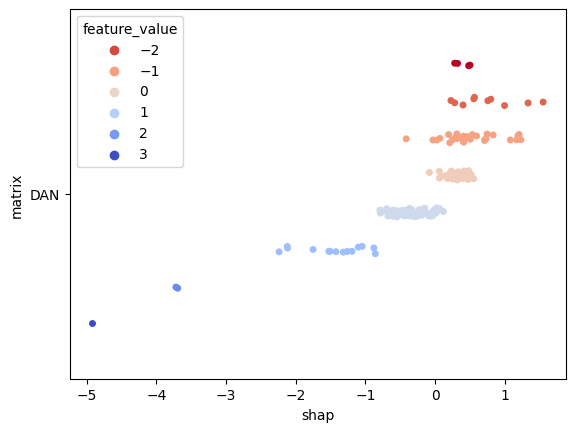